# A Walk Through Ensemble Models
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Please check the pdf file for more details.*

In this exercise you will:

- get to know a useful package **pandas** for data analysis/preprocessing
- implement **decision tree** and apply it to a Titanic dataset
- implement a whole bunch of **ensemble methods**, including **random forest, and adaboost**, and apply them to a Titanic dataset

Please note that **YOU CANNOT USE ANY MACHINE LEARNING PACKAGE SUCH AS SKLEARN** for any homework, unless you are asked to.

In [1]:
# some basic imports
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Let's first do some data preprocessing

Here we use [pandas](https://pandas.pydata.org/) to do data preprocessing. Pandas is a very popular and handy package for data science or machine learning. You can also refer to this official guide for pandas: [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)

In [2]:
# read titanic train and test data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

print("train shape: {} test shape: {}".format(train.shape, test.shape))
# Showing overview of the train dataset
train.head(3)

train shape: (1047, 11) test shape: (262, 11)


,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,11767,83.1583,C54,C
1,3,0,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S
2,3,0,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S


## deal with missing values and transform to discrete variables

In [3]:
# copied from: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head()

,Pclass,Survived,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,1,0,1,0,3,1,1,1,1,4
1,3,0,1,2,0,0,0,0,1,1,1
2,3,0,1,2,0,1,0,0,3,0,1
3,3,0,1,1,0,0,2,0,1,1,1
4,2,0,1,2,0,1,0,0,1,1,1


One of the good thing of pd.DataFrame is that you can keep the column names along with the data, which can be beneficial for many case.

Another good thing is that pd.DataFrame can be converted to np.array implicitely.

Also, pd provides a lot of useful data manipulating methods for your convenience, though we may not use them in this homework.

In [6]:
X = train.drop(['Survived'], axis=1)
y = train["Survived"]
X_test = test.drop(['Survived'], axis=1)
y_test = test["Survived"]
print("train: {}, test: {}".format(X.shape, X_test.shape))

train: (1047, 10), test: (262, 10)


In [7]:
def accuracy(y_gt, y_pred):
    return np.sum(y_gt == y_pred) / y_gt.shape[0]

In [8]:
print("Survived: {:.4f}, Not Survivied: {:.4f}".format(y.sum() / len(y), 1 - y.sum() / len(y)))

Survived: 0.3878, Not Survivied: 0.6122


## Decision Tree
Now it's your turn to do some real coding. Please implement the decision tree model in **decision_tree.py**. The PDF file provides some hints for this part.

Accuracy on train set: 0.8013371537726839


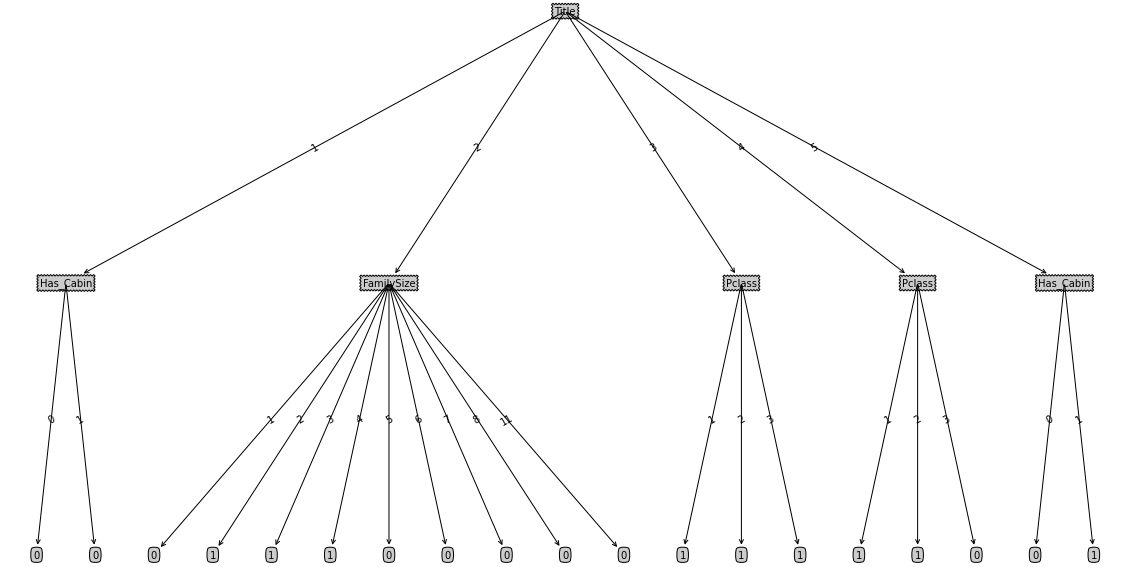

In [11]:
from decision_tree import DecisionTree

dt = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=1, sample_feature=False)
#dt = DecisionTree(criterion='gini', max_depth=4, min_samples_leaf=1, sample_feature=False)
#dt = DecisionTree(criterion='infogain_ratio', max_depth=5, min_samples_leaf=2, sample_feature=False)
dt.fit(X, y)

y_train_pred = dt.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

# Plot the decision tree to get an intuition about how it makes decision
plt.figure(figsize=(20, 10))
dt.show()

In [24]:
# TODO: Train the best DecisionTree(best val accuracy) that you can. You should choose some 
# hyper-parameters such as critertion, max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# To reduce difficulty, you can use KFold here.
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

methods = ['entropy', 'infogain_ratio', 'gini']
max_depth=list(range(2,7))
min_nodes=[1,10,20,50]

best_acc = 0.0

for method in methods:
    for depth in max_depth:
        for num in min_nodes:
            dt = DecisionTree(criterion=method, max_depth=depth, min_samples_leaf=num, sample_feature=False)
            acc=0.0
            for train_indice, valid_indice in kf.split(X, y):
                X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                #print(X_train_fold.shape, X_val_fold.shape)
                dt.fit(X_train_fold, y_train_fold)
                y_val_pred = dt.predict(X_val_fold)
                acc+=accuracy(y_val_fold, y_val_pred)
            acc/=5
            if best_acc<acc:
                best_acc = acc
                best_method = method
                best_depth = depth
                best_num = num
print(best_method)
print('depth={}, leaf = {}, acc={}'.format(best_depth,best_num,best_acc))

                


infogain_ratio
depth=3, leaf = 20, acc=0.8061152882205513


In [25]:
# report the accuracy on test set
# begin answer
# end answer
dt = DecisionTree(criterion='infogain_ratio', max_depth=3, min_samples_leaf=20, sample_feature=False)
dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, dt.predict(X_test))))

Accuracy on train set: 0.8127984718242598
Accuracy on test set: 0.7900763358778626


## Random Forest
Please implement the random forest model in **random_forest.py**. The PDF file provides some hints for this part.

In [73]:
from random_forest import RandomForest

base_learner = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=1, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=100, seed=2020)
rf.fit(X, y)

y_train_pred = rf.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.8089780324737345


In [77]:
# TODO: Train the best RandomForest that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)


base_learner = DecisionTree(criterion='entropy', max_depth=8, min_samples_leaf=20, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=60, seed=2020)
acc=0.0
for train_indice, valid_indice in kf.split(X, y):
    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
    #print(X_train_fold.shape, X_val_fold.shape)
    rf.fit(X_train_fold, y_train_fold)
    y_val_pred = rf.predict(X_val_fold)
    acc+=accuracy(y_val_fold, y_val_pred)
acc/=5
print(acc)
# end answer

0.7774800637958532


In [105]:
# report the accuracy on test set
# begin answer
# end answer
base_learner = DecisionTree(criterion='entropy', max_depth=8, min_samples_leaf=10, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=10, seed=2020)
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

Accuracy on train set: 0.8500477554918816
Accuracy on test set: 0.816793893129771


## Adaboost
Please implement the adaboost model in **adaboost.py**. The PDF file provides some hints for this part.

In [102]:
from adaboost import Adaboost

base_learner = DecisionTree(criterion='entropy', max_depth=1, min_samples_leaf=1, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=20, seed=2020)
ada.fit(X, y)

y_train_pred = ada.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.8080229226361032


In [95]:
# TODO: Train the best Adaboost that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer
acc=0.0
for train_indice, valid_indice in kf.split(X, y):
    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
    #print(X_train_fold.shape, X_val_fold.shape)
    ada.fit(X_train_fold, y_train_fold)
    y_val_pred = ada.predict(X_val_fold)
    acc+=accuracy(y_val_fold, y_val_pred)
    
acc/=5
print(1-acc)
# end answer

0.19864205969469118


In [97]:
# report the accuracy on test set
# begin answer
# end answer
base_learner = DecisionTree(criterion='entropy', max_depth=2, min_samples_leaf=20, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=50, seed=2020)
ada.fit(X, y)

print("Accuracy on train set: {}".format(accuracy(y, ada.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, ada.predict(X_test))))

Accuracy on train set: 0.8299904489016237
Accuracy on test set: 0.8244274809160306


# Compare

linear regression

In [111]:
from sklearn.linear_model import LinearRegression
y_ = np.where(y==1,1,-1)
res = LinearRegression().fit(X,y_)
y_train = res.predict (X)
y_train = np.where(y_train>0, 1,0)
y_pre= res.predict(X_test)
y_pre = np.where(y_pre>0, 1,0)
print("Accuracy on train set: {}".format(accuracy(y, y_train)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_pre)))

Accuracy on train set: 0.7917860553963706
Accuracy on test set: 0.7862595419847328


naive bayes

In [112]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, clf.predict(X) )))
print("Accuracy on test set: {}".format(accuracy(y_test, clf.predict(X_test))))

Accuracy on train set: 0.7650429799426934
Accuracy on test set: 0.7748091603053435


Perceptron

In [121]:
from sklearn.linear_model import Perceptron
per = Perceptron(eta0 = 0.1)
per.fit(X,y)
print("Accuracy on train set: {}".format(accuracy(y, per.predict(X) )))
print("Accuracy on test set: {}".format(accuracy(y_test, per.predict(X_test))))

Accuracy on train set: 0.7640878701050621
Accuracy on test set: 0.7786259541984732


KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier
k=10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X,y)
print("Accuracy on train set: {}".format(accuracy(y, knn.predict(X) )))
print("Accuracy on test set: {}".format(accuracy(y_test, knn.predict(X_test))))

Accuracy on train set: 0.8185291308500477
Accuracy on test set: 0.816793893129771


Logistic Regression

In [128]:
from sklearn.linear_model import LogisticRegression
y_ = np.where(y==1,1,-1)
res = LogisticRegression().fit(X,y_)
y_train = res.predict (X)
y_train = np.where(y_train>0, 1,0)
y_pre= res.predict(X_test)
y_pre = np.where(y_pre>0, 1,0)
print("Accuracy on train set: {}".format(accuracy(y, y_train)))
print("Accuracy on test set: {}".format(accuracy(y_test, y_pre)))

Accuracy on train set: 0.7975167144221585
Accuracy on test set: 0.7900763358778626


SVM

In [129]:
from sklearn import svm#导出svm
clf = svm.SVC()#实例化
clf.fit(X, y)#拟合
print("Accuracy on train set: {}".format(accuracy(y, clf.predict(X) )))
print("Accuracy on test set: {}".format(accuracy(y_test, clf.predict(X_test))))

Accuracy on train set: 0.8185291308500477
Accuracy on test set: 0.816793893129771


neural network

In [133]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
nn.fit(X,y)
print("Accuracy on train set: {}".format(accuracy(y, nn.predict(X) )))
print("Accuracy on test set: {}".format(accuracy(y_test, nn.predict(X_test))))

Accuracy on train set: 0.8194842406876791
Accuracy on test set: 0.8206106870229007


F:\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
